## Detekcja dłoni przy użyciu modelu mediapipe

### Import modułów używanych do projektu:

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import torch

In [4]:
mp_holistic = mp.solutions.holistic          #import modelu wykrywającego cialo mediapipe
mp_drawing = mp.solutions.drawing_utils      #import narzędzi do oznaczania detekcji na obrazie

### Funkcja pozwalająca przeprocesować klatki filmu modelowi mediapipe:

In [5]:
def mediapipe_det(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #konwersja kolorów BGR na RGB klatki
    image.flags.writeable = False                  #zarządzanie pamięcią dla np.array
    results = model.process(image)                 #processowanie klatki za pomocą modelu mediapipe
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

### Funkcja zwracająca klatki z narysowanymi liniamii dłoni:

In [6]:
def draw_hands(image, results):
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

### Funkcja otwierająca oraz zapisująca wideo, oraz implementująca poprzednie funkcje napisane wyżej:

In [8]:
cap = cv2.VideoCapture('trim1.mp4')                            #otwarcie pliku ze ścieżki
size = (int(cap.get(3)), int(cap.get(4)))                      #określenie rozdzielczości
fps =  int(cap.get(cv2.CAP_PROP_FPS))                          #określenie fps filmu
output = cv2.VideoWriter('test1.mp4', cv2.VideoWriter.fourcc(*'mp4v'), fps,size)         #funkcja opencv zapisująca wynik

with mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence = 0.3) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()                                     #odczytanie klatek z filmu, ret - ilość pozostałych klatek, frame - "obraz" klatki
        if not ret:                                                 # przerwanie pętli, kiedy nie ma juz pozostałych klatek do przerobienia
            break
            
        image, results = mediapipe_det(frame, holistic)             # procesowanie klatki przez model mediapipe
        
        draw_hands(image, results)                                  # rysowanie lini dłoni
            
        output.write(image)                                         # zapisywanie zmienionych klatek i łączenie je z powrotem w film

        cv2.imshow("OpenCV Feed", image)                            # podgląd "live"
        if cv2.waitKey(0) & 0xFF == ord('w'):                       # zamknięcie okna opencv za pomoca przycisku 'w'
            break

    cap.release()
    output.release()
    cv2.destroyAllWindows()

## Detekcja dłoni przy użyciu YOLOv5m na podstawie 100 zanotowanych klatek z różnych filmów

#### Zmiana rozdzielczości klatek

In [ ]:
from PIL import Image
import os
import torchvision.transforms as T

dir = '/home/piotr/Neural_test/PM_testy/yolov5/data/images'  # określenie ścieżki do przeanotowanych klatek
transform = T.Resize((640,640))

for filename in os.listdir(dir):
    img = Image.open(filename)
    print(img.size)
    img = transform(img)
    print(img.size)
    img = img.save(filename)  # zmiana rozdzielczosci klatek do 640x640 pixeli

#### Trening modelu

In [ ]:
!python train.py --imgsz 640 --epochs 500 --batch 4 --data dataset.yaml --weights yolov5m.pt 

#### Załadowanie modelu z pomocą danych z wytrenowanego modułu YOLOv5

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/home/piotr/Neural_test/PM_testy/yolov5/runs/train/exp30/weights/best.pt', force_reload=True)

#### Wyświetlenie klatki z detekcją modelu YOLOv5

In [ ]:
%cd ./yolov5

In [5]:
img = os.path.join('data','images','02.jpg')

In [6]:
results = model(img)

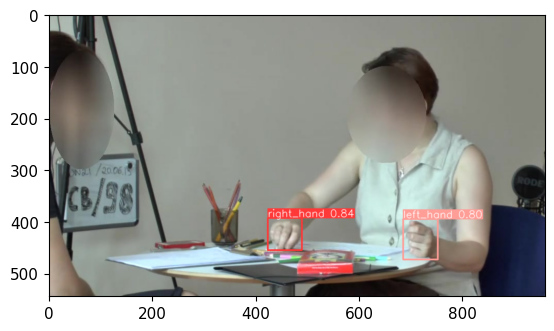

In [7]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

#### Detekcja dłoni za pomocą modelu YOLOv5 na całym filmie i zapisanie rezultatów

In [36]:
cap = cv2.VideoCapture('trim3_anonymized.mp4')                  #otwarcie pliku ze ścieżki
size = (int(cap.get(3)), int(cap.get(4)))                       #określenie rozdzielczości
fps =  int(cap.get(cv2.CAP_PROP_FPS))                           #określenie fps filmu
output = cv2.VideoWriter('test1.mp4', cv2.VideoWriter.fourcc(*'mp4v'), fps,size) 
while cap.isOpened():
    ret, frame = cap.read()                                     #odczytanie klatek z filmu, ret - ilość pozostałych klatek, frame - "obraz" klatki
    if not ret:                                                 # przerwanie pętli, kiedy nie ma juz pozostałych klatek do przerobienia
        break
            
    results = model(frame)                                      # procesowanie klatki przez model YOLOv5m
            
    output.write(np.squeeze(results.render()))                  # zapisywanie zmienionych klatek i łączenie je z powrotem w film

    cv2.imshow('Yolo', np.squeeze(results.render()))            # podgląd "live"
    if cv2.waitKey(0) & 0xFF == ord('w'):                       # zamknięcie okna opencv za pomoca przycisku 'w'
        break

cap.release()
output.release()
cv2.destroyAllWindows()